In [1]:
# This is the main file for the implementation of volatility managed portfolios
# As part of the Master Project for the Msc in Financial Engineering at EDHEC Buusiness School
# Property of Wiktor Kotwicki, Moana Valdenaire, and Nicolas Gamboa Alvarez
# EDHEC Business School, 2024-2025

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Importing the data for European Index Futures
euroindex_PX_BID = pd.read_excel('Futures Prices.xlsx', sheet_name='INDEX PX_BID')
euroindex_PX_ASK = pd.read_excel('Futures Prices.xlsx', sheet_name='INDEX PX_ASK')
euroindex_PX_SETTLE = pd.read_excel('Futures Prices.xlsx', sheet_name='INDEX PX_SETTLE')

In [4]:
# Importing the data for Commodity Futures for metals
metals_PX_BID = pd.read_excel('Futures Prices.xlsx', sheet_name='COMMDTY PX_BID')
metals_PX_ASK = pd.read_excel('Futures Prices.xlsx', sheet_name='COMMDTY PX_ASK')
metals_PX_SETTLE = pd.read_excel('Futures Prices.xlsx', sheet_name='COMMDTY PX_SETTLE')

In [5]:
# Importing the data for the risk-free rate
risk_free_rate = pd.read_excel('Futures Prices.xlsx', sheet_name='RFRS PX_ASK')

In [6]:
# Treating the data - dates
euroindex_PX_BID['DATE'] = pd.to_datetime(euroindex_PX_BID['DATE'], format='%m/%d/%Y')
euroindex_PX_ASK['DATE'] = pd.to_datetime(euroindex_PX_ASK['DATE'], format='%m/%d/%Y')
euroindex_PX_SETTLE['DATE'] = pd.to_datetime(euroindex_PX_SETTLE['DATE'], format='%m/%d/%Y')
metals_PX_BID['DATE'] = pd.to_datetime(metals_PX_BID['DATE'], format='%m/%d/%Y')
metals_PX_ASK['DATE'] = pd.to_datetime(metals_PX_ASK['DATE'], format='%m/%d/%Y')
metals_PX_SETTLE['DATE'] = pd.to_datetime(metals_PX_SETTLE['DATE'], format='%m/%d/%Y')
risk_free_rate['DATE'] = pd.to_datetime(risk_free_rate['DATE'], format='%m/%d/%Y')

In [7]:
# Setting the date as the index for the dataframes
euroindex_PX_BID.set_index('DATE', inplace=True)
euroindex_PX_ASK.set_index('DATE', inplace=True)
euroindex_PX_SETTLE.set_index('DATE', inplace=True)
metals_PX_BID.set_index('DATE', inplace=True)
metals_PX_ASK.set_index('DATE', inplace=True)
metals_PX_SETTLE.set_index('DATE', inplace=True)
risk_free_rate.set_index('DATE', inplace=True)

In [8]:
# Since data is downloades from Bloomberg
# The first row is normally saves as an error #NAME
# Therefore we remove the first row
euroindex_PX_BID = euroindex_PX_BID.iloc[1:]
euroindex_PX_ASK = euroindex_PX_ASK.iloc[1:]
euroindex_PX_SETTLE = euroindex_PX_SETTLE.iloc[1:]
metals_PX_BID = metals_PX_BID.iloc[1:]
metals_PX_ASK = metals_PX_ASK.iloc[1:]
metals_PX_SETTLE = metals_PX_SETTLE.iloc[1:]
risk_free_rate = risk_free_rate.iloc[1:]

In [9]:
# Creating a list of all the tickers for the futures - which are the columns in the dataframes
euroindex_bbg_tickers = euroindex_PX_BID.columns.tolist()
metals_bbg_tickers = metals_PX_BID.columns.tolist()

In [10]:
# Printing the tickers
print("Euroindex tickers:")
for ticker in euroindex_bbg_tickers:
    print(ticker)

Euroindex tickers:
GX1 Index
GX2 Index
CF1 Index
CF2 Index
AJ1 Index
AJ2 Index
ST1 Index
ST2 Index
EO1 Index
EO2 Index
PP1 Index
PP2 Index
IB1 Index
IB2 Index
BE1 Index
BE2 Index


In [11]:
print("Metals tickers:")
for ticker in metals_bbg_tickers:
    print(ticker)

Metals tickers:
GC1 Comdty
GC2 Comdty
SI1 Comdty
SI2 Comdty
PL1 Comdty
PL2 Comdty
PA1 Comdty
PA2 Comdty
LN1 Comdty
LN2 Comdty
LX1 Comdty
LX2 Comdty
LT1 Comdty
LT2 Comdty
LP1 Comdty
LP2 Comdty
LA1 Comdty
LA2 Comdty


In [12]:
# Importing the dictionaries for the futures contracts
euro_index_futures_dict = pd.read_excel('Futures Prices.xlsx', sheet_name='EURO INDEXES FUTURES >')
metal_futures_dict = pd.read_excel('Futures Prices.xlsx', sheet_name='METAL FUTURES >')

In [13]:
# Eliminating the column 'NOTES' from metal_futures_dict and eliminating the last 5 rows (comments)
metal_futures_dict = metal_futures_dict.iloc[:-5]
metal_futures_dict = metal_futures_dict.drop(columns=['NOTES'])

In [14]:
print(euro_index_futures_dict)

    BBG CODE           INDEX      COUNTRY    CONTRACT SIZE  VALUE OF 1.0 PT  \
0  GX1 Index           DAX30      Germany   25 EUR x index               25   
1  CF1 Index           CAC40       France   10 EUR x index               10   
2  AJ1 Index  FTSE Athens 20       Greece    2 EUR x index                2   
3  ST1 Index        FTSE MIB        Italy    5 EUR x indes                5   
4  EO1 Index             AEX  Netherlands  200 EUR x index              200   
5  PP1 Index           PSI20     Portugal    1 EUR x index                1   
6  IB1 Index          IBEX35        Spain  10 EUR  x index               10   
7  BE1 Index           BEL20      Belgium   10 EUR x index               10   

   TICK SIZE  TICK VALUE                              EXCHANGE  
0       1.00        25.0                             EUX-Eurex  
1       0.50         5.0      EUP-Euronext Derivatives - Paris  
2       0.25         0.5        ADE-Athens Derivative Exchange  
3       5.00        25.0    

In [15]:
print(metal_futures_dict)

     BBG CODE  COMMODITY   CONTRACT SIZE                     EXCHANGE
0  GC1 Comdty       Gold    100 troy oz.  GMX-COMEX division of NYMEX
1  SI1 Comdty     Silver   5000 troy oz.  GMX-COMEX division of NYMEX
2  PL1 Comdty   Platinum     50 troy oz.           NYM-NYMEX Exchange
3  PA1 Comdty  Palladium    100 troy oz.           NYM-NYMEX Exchange
4  LN1 Comdty     Nickel   6 metric tons    LME-LME Benchmark Monitor
5  LX1 Comdty       Zinc  25 metric tons    LME-LME Benchmark Monitor
6  LT1 Comdty        Tin   5 metric tons    LME-LME Benchmark Monitor
7  LP1 Comdty     Copper  25 metric tons    LME-LME Benchmark Monitor
8  LA1 Comdty   Aluminum  25 metric tons    LME-LME Benchmark Monitor


In [16]:
# Creating a class for a futures contract
# The cass will contain the following attributes:
# - underlying asset name
# - first maturity ticker
# - second maturity ticker
# - time series of the bid prices of the first maturity
# - time series of the bid prices of the second maturity
# - time series of the ask prices of the first maturity
# - time series of the ask prices of the second maturity
# - time series of the settlement prices of the first maturity
# - time series of the settlement prices of the second maturity
# - time series of the risk-free rate
# - TODO LATER time series of the next settlement/maturity date of the futures contract

class FuturesContract:
    def __init__(self, underlying_asset_name, first_maturity_ticker, second_maturity_ticker,
                 first_maturity_bid_prices, second_maturity_bid_prices,
                 first_maturity_ask_prices, second_maturity_ask_prices,
                 first_maturity_settlement_prices, second_maturity_settlement_prices,
                 risk_free_rate, estimation_window=252):
        
            time_series = [first_maturity_bid_prices, second_maturity_bid_prices,
                           first_maturity_ask_prices, second_maturity_ask_prices,
                           first_maturity_settlement_prices, second_maturity_settlement_prices,
                           risk_free_rate]
            
            strings = [underlying_asset_name, first_maturity_ticker, second_maturity_ticker]
            # Vatidating the input parameters
            # Check if all the strings are non-empty string
            if not all(isinstance(s, str) and s.strip() for s in strings):
                raise ValueError("All string parameters must be non-empty strings: underlying_asset_name, first_maturity_ticker, second_maturity_ticker")
            # Check that all the time series are pandas DataFrames
            if not all(isinstance(ts, pd.DataFrame) for ts in time_series):
                raise ValueError("All time series must be pandas DataFrames")
            # Check that all time series have the same index
            if not all(ts.index.equals(time_series[0].index) for ts in time_series[1:]):
                raise ValueError("All time series must have the same index")
            # Checking if the estimation window is a positive integer
            if not isinstance(estimation_window, int) or estimation_window <= 0:
                raise ValueError("Estimation window must be a positive integer")
            
            # For calculating the bid-ask spreads
            def calculate_bid_ask_spread(bid_prices, ask_prices, pct=False):
                if pct:
                    return (ask_prices - bid_prices) / ((ask_prices + bid_prices)/2)
                else:
                    return ask_prices - bid_prices
                
            def estimate_dollar_index_naive(bid_prices, ask_prices):
                mid_prices = (bid_prices + ask_prices) / 2
                starting_price = mid_prices.iloc[0]
                # Creating a time series of the dollar index
                dollar_index = (mid_prices / starting_price) * 100
                return dollar_index
                
            def estimate_transaction_cost(bid_ask_spread):
                return bid_ask_spread/2
            
            # Assigning attributes to the class
            self.underlying_asset_name = underlying_asset_name
            self.first_maturity_ticker = first_maturity_ticker
            self.second_maturity_ticker = second_maturity_ticker
            self.first_maturity_bid_prices = first_maturity_bid_prices
            self.second_maturity_bid_prices = second_maturity_bid_prices
            self.first_maturity_ask_prices = first_maturity_ask_prices
            self.second_maturity_ask_prices = second_maturity_ask_prices
            self.first_maturity_settlement_prices = first_maturity_settlement_prices
            self.second_maturity_settlement_prices = second_maturity_settlement_prices
            self.risk_free_rate = risk_free_rate
            self.estimation_window = estimation_window
            
            # Calculating the bid-ask spread time series
            self.bid_ask_spreads = calculate_bid_ask_spread(self.first_maturity_bid_prices, self.first_maturity_ask_prices)
            self.bid_ask_spreads_pct = calculate_bid_ask_spread(self.first_maturity_bid_prices, self.first_maturity_ask_prices, pct=True)
            self.transaction_costs = estimate_transaction_cost(self.bid_ask_spreads)
            self.transaction_costs_pct = estimate_transaction_cost(self.bid_ask_spreads_pct)
            
            # Calculating the time series of the estimated volatility using a rolling window
            self.rolling_volatility_bid = self.first_maturity_bid_prices.rolling(window=self.estimation_window).std()
            self.rolling_volatility_ask = self.first_maturity_ask_prices.rolling(window=self.estimation_window).std()
            self.rolling_volatility_settlement = self.first_maturity_settlement_prices.rolling(window=self.estimation_window).std()
            self.rolling_volatility_bid_ask_spread = self.bid_ask_spreads_pct.rolling(window=self.estimation_window).std()
            
            # Calculating the dollar index using the naive method
            self.dollar_index_naive = estimate_dollar_index_naive(self.first_maturity_bid_prices, self.first_maturity_ask_prices)


In [17]:
# DAX30 index futures contract:
DAX30_futures = FuturesContract(
    underlying_asset_name='DAX30',
    first_maturity_ticker='GX1 Index',
    second_maturity_ticker='GX2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['GX1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['GX2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['GX1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['GX2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['GX1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['GX2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# CAC40 index futures contract:
CAC40_futures = FuturesContract(
    underlying_asset_name='CAC40',
    first_maturity_ticker='CF1 Index',
    second_maturity_ticker='CF2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['CF1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['CF2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['CF1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['CF2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['CF1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['CF2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# FTSE Athens 20 index futures contract:
FTSE_Athens_20_futures = FuturesContract(
    underlying_asset_name='FTSE Athens 20',
    first_maturity_ticker='AJ1 Index',
    second_maturity_ticker='AJ2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['AJ1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['AJ2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['AJ1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['AJ2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['AJ1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['AJ2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# FTSE MIB index futures contract:
FTSE_MIB_futures = FuturesContract(
    underlying_asset_name='FTSE MIB',
    first_maturity_ticker='ST1 Index',
    second_maturity_ticker='ST2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['ST1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['ST2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['ST1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['ST2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['ST1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['ST2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# AEX index futures contract:
AEX_futures = FuturesContract(
    underlying_asset_name='AEX',
    first_maturity_ticker='EO1 Index',
    second_maturity_ticker='EO2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['EO1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['EO2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['EO1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['EO2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['EO1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['EO2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# PSI20 index futures contract:
PSI20_futures = FuturesContract(
    underlying_asset_name='PSI20',
    first_maturity_ticker='PP1 Index',
    second_maturity_ticker='PP2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['PP1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['PP2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['PP1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['PP2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['PP1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['PP2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# IBEX 35 index futures contract:
IBEX_35_futures = FuturesContract(
    underlying_asset_name='IBEX 35',
    first_maturity_ticker='IB1 Index',
    second_maturity_ticker='IB2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['IB1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['IB2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['IB1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['IB2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['IB1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['IB2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)

# BEL20 index futures contract:
BEL20_futures = FuturesContract(
    underlying_asset_name='BEL20',
    first_maturity_ticker='BE1 Index',
    second_maturity_ticker='BE2 Index',
    first_maturity_bid_prices=euroindex_PX_BID[['BE1 Index']],
    second_maturity_bid_prices=euroindex_PX_BID[['BE2 Index']],
    first_maturity_ask_prices=euroindex_PX_ASK[['BE1 Index']],
    second_maturity_ask_prices=euroindex_PX_ASK[['BE2 Index']],
    first_maturity_settlement_prices=euroindex_PX_SETTLE[['BE1 Index']],
    second_maturity_settlement_prices=euroindex_PX_SETTLE[['BE2 Index']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=20
)


ValueError: All time series must have the same index

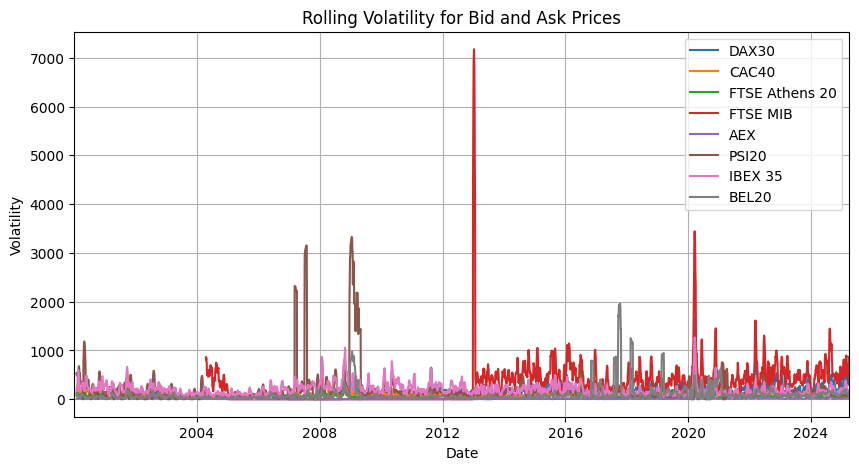

In [ ]:
# Visualizing the rolling volatility for bid and ask prices for all the futures contracts
plt.figure(figsize=(10, 5))
# Generate a color palette with the same number of colors as the futures contracts
color_palette = sns.color_palette("tab10", 8)

# List of futures contracts and their labels
futures_contracts = [
    (DAX30_futures, 'DAX30'),
    (CAC40_futures, 'CAC40'),
    (FTSE_Athens_20_futures, 'FTSE Athens 20'),
    (FTSE_MIB_futures, 'FTSE MIB'),
    (AEX_futures, 'AEX'),
    (PSI20_futures, 'PSI20'),
    (IBEX_35_futures, 'IBEX 35'),
    (BEL20_futures, 'BEL20')
]

# Plot each futures contract with the corresponding color
for (futures, label), color in zip(futures_contracts, color_palette):
    plt.plot(futures.rolling_volatility_bid, label=label, color=color, alpha=1)
plt.title('Rolling Volatility for Bid and Ask Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(DAX30_futures.rolling_volatility_bid.index.min(), DAX30_futures.rolling_volatility_bid.index.max())
plt.legend()
plt.grid()
plt.show()

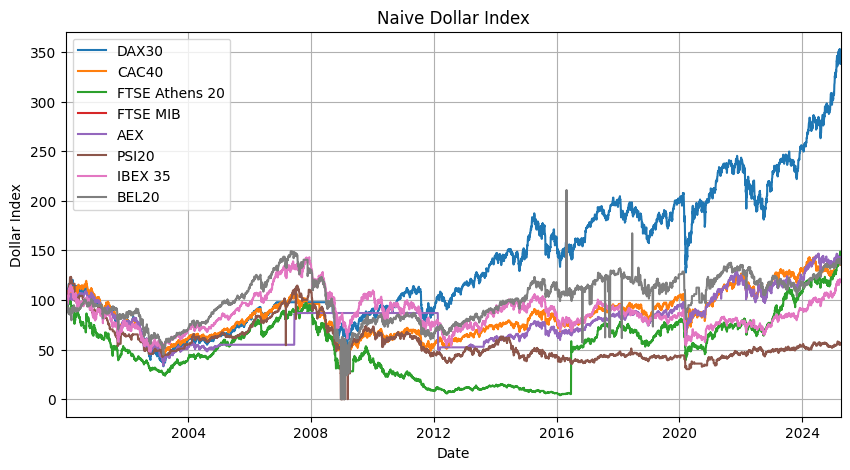

In [ ]:
# Visualizing the naive dollar index for all the futures contracts
plt.figure(figsize=(10, 5))
for (futures, label), color in zip(futures_contracts, color_palette):
    plt.plot(futures.dollar_index_naive, label=label, color=color, alpha=1)
plt.title('Naive Dollar Index')
plt.xlabel('Date')
plt.ylabel('Dollar Index')
plt.xlim(DAX30_futures.dollar_index_naive.index.min(), DAX30_futures.dollar_index_naive.index.max())
plt.legend()
plt.grid()
plt.show()

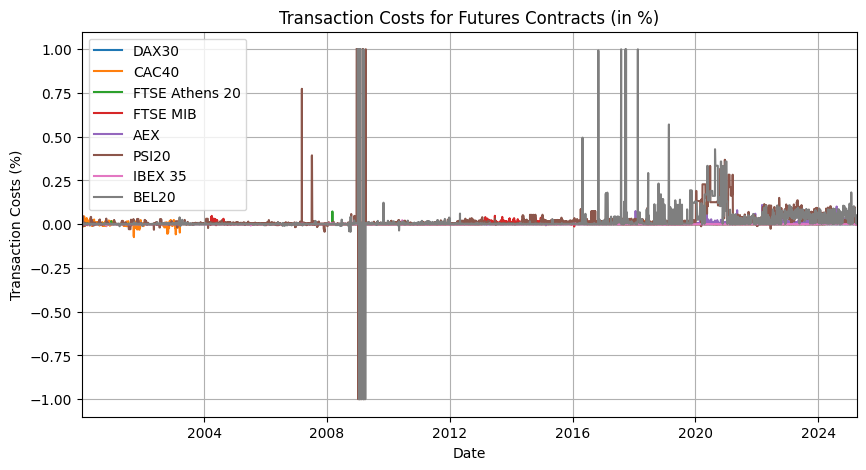

In [ ]:
# Visualizing the transaction costs for all the futures contracts in percentage
plt.figure(figsize=(10, 5))
for (futures, label), color in zip(futures_contracts, color_palette):
    plt.plot(futures.transaction_costs_pct, label=label, color=color, alpha=1)
plt.title('Transaction Costs for Futures Contracts (in %)')
plt.xlabel('Date')
plt.ylabel('Transaction Costs (%)')
plt.xlim(DAX30_futures.transaction_costs_pct.index.min(), DAX30_futures.transaction_costs_pct.index.max())
plt.legend()
plt.grid()
plt.show()

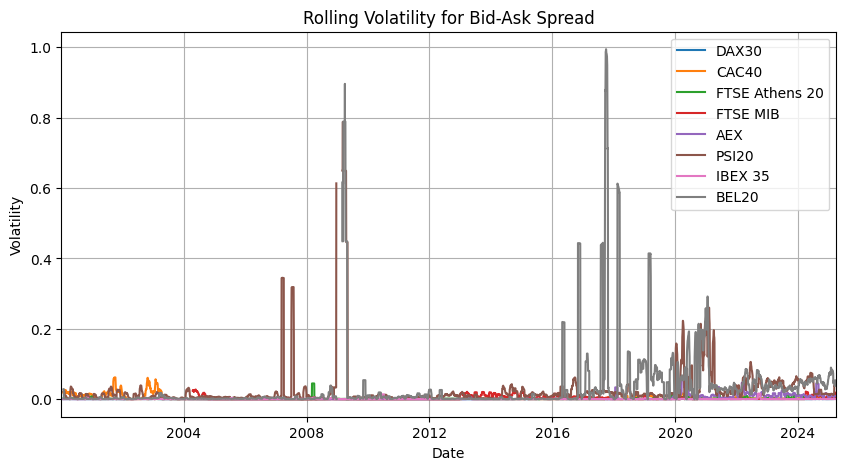

In [ ]:
# Visualizing the rolling volatility for the bid ask spread for all the futures contracts
plt.figure(figsize=(10, 5))

# Plot each futures contract with the corresponding color
for (futures, label), color in zip(futures_contracts, color_palette):
    plt.plot(futures.rolling_volatility_bid_ask_spread, label=label, color=color, alpha=1)
plt.title('Rolling Volatility for Bid-Ask Spread')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(DAX30_futures.rolling_volatility_bid_ask_spread.index.min(), DAX30_futures.rolling_volatility_bid_ask_spread.index.max())
plt.legend()
plt.grid()
plt.show()

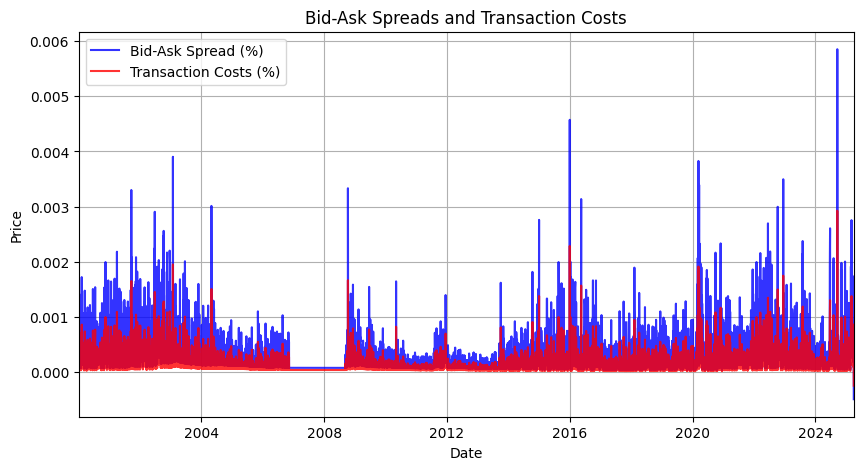

In [ ]:
# Visualizing the bid-ask spreads and transaction costs
plt.figure(figsize=(10, 5))
plt.plot(DAX30_futures.bid_ask_spreads_pct, label='Bid-Ask Spread (%)', color='blue', alpha=0.8)
plt.plot(DAX30_futures.transaction_costs_pct, label='Transaction Costs (%)', color='red', alpha=0.8)
plt.title('Bid-Ask Spreads and Transaction Costs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim(DAX30_futures.bid_ask_spreads_pct.index.min(), DAX30_futures.bid_ask_spreads_pct.index.max())
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Gold futures contract:
gold_futures = FuturesContract(
    underlying_asset_name='Gold',
    first_maturity_ticker='GC1 Comdty',
    second_maturity_ticker='GC2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['GC1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['GC2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['GC1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['GC2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['GC1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['GC2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Silver futures contract:
silver_futures = FuturesContract(
    underlying_asset_name='Silver',
    first_maturity_ticker='SI1 Comdty',
    second_maturity_ticker='SI2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['SI1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['SI2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['SI1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['SI2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['SI1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['SI2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Platinum futures contract:
platinum_futures = FuturesContract(
    underlying_asset_name='Platinum',
    first_maturity_ticker='PL1 Comdty',
    second_maturity_ticker='PL2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['PL1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['PL2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['PL1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['PL2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['PL1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['PL2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Palladium futures contract:
palladium_futures = FuturesContract(
    underlying_asset_name='Palladium',
    first_maturity_ticker='PA1 Comdty',
    second_maturity_ticker='PA2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['PA1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['PA2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['PA1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['PA2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['PA1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['PA2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Nickel futures contract:
nickel_futures = FuturesContract(
    underlying_asset_name='Nickel',
    first_maturity_ticker='LN1 Comdty',
    second_maturity_ticker='LN2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['LN1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['LN2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['LN1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['LN2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['LN1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['LN2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Zinc futures contract:
zinc_futures = FuturesContract(
    underlying_asset_name='Zinc',
    first_maturity_ticker='LX1 Comdty',
    second_maturity_ticker='LX2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['LX1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['LX2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['LX1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['LX2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['LX1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['LX2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Tin futures contract:
tin_futures = FuturesContract(
    underlying_asset_name='Tin',
    first_maturity_ticker='LT1 Comdty',
    second_maturity_ticker='LT2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['LT1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['LT2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['LT1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['LT2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['LT1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['LT2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Copper futures contract:
copper_futures = FuturesContract(
    underlying_asset_name='Copper',
    first_maturity_ticker='LP1 Comdty',
    second_maturity_ticker='LP2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['LP1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['LP2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['LP1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['LP2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['LP1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['LP2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

# Aluminum futures contract:
aluminum_futures = FuturesContract(
    underlying_asset_name='Aluminum',
    first_maturity_ticker='LA1 Comdty',
    second_maturity_ticker='LA2 Comdty',
    first_maturity_bid_prices=metals_PX_BID[['LA1 Comdty']],
    second_maturity_bid_prices=metals_PX_BID[['LA2 Comdty']],
    first_maturity_ask_prices=metals_PX_ASK[['LA1 Comdty']],
    second_maturity_ask_prices=metals_PX_ASK[['LA2 Comdty']],
    first_maturity_settlement_prices=metals_PX_SETTLE[['LA1 Comdty']],
    second_maturity_settlement_prices=metals_PX_SETTLE[['LA2 Comdty']],
    risk_free_rate=risk_free_rate[['EUR001M Index']],
    estimation_window=252
)

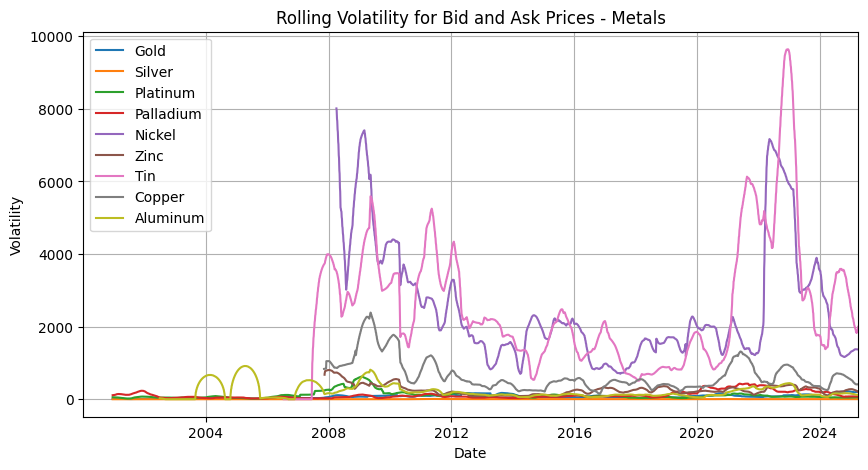

In [ ]:
# Visualizing the rolling volatility for bid and ask prices for all the metals futures contracts
plt.figure(figsize=(10, 5))
# Generate a color palette with the same number of colors as the futures contracts
color_palette = sns.color_palette("tab10", 9)

# List of futures contracts and their labels
futures_contracts_metals = [
    (gold_futures, 'Gold'),
    (silver_futures, 'Silver'),
    (platinum_futures, 'Platinum'),
    (palladium_futures, 'Palladium'),
    (nickel_futures, 'Nickel'),
    (zinc_futures, 'Zinc'),
    (tin_futures, 'Tin'),
    (copper_futures, 'Copper'),
    (aluminum_futures, 'Aluminum')
]

# Plot each futures contract with the corresponding color
for (futures, label), color in zip(futures_contracts_metals, color_palette):
    plt.plot(futures.rolling_volatility_bid, label=label, color=color, alpha=1)
plt.title('Rolling Volatility for Bid and Ask Prices - Metals')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(gold_futures.rolling_volatility_bid.index.min(), gold_futures.rolling_volatility_bid.index.max())
plt.legend()
plt.grid()
plt.show()

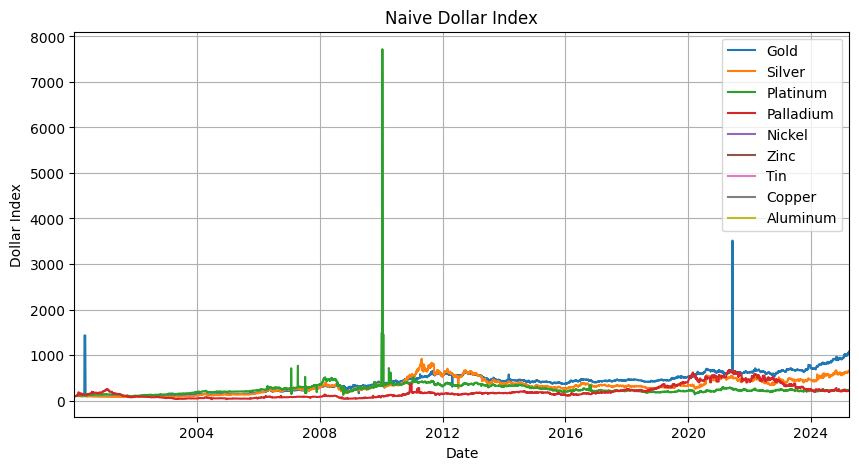

In [ ]:
# Visualizing the naive dollar index for all the futures contracts
plt.figure(figsize=(10, 5))
for (futures, label), color in zip(futures_contracts_metals, color_palette):
    plt.plot(futures.dollar_index_naive, label=label, color=color, alpha=1)
plt.title('Naive Dollar Index')
plt.xlabel('Date')
plt.ylabel('Dollar Index')
plt.xlim(DAX30_futures.dollar_index_naive.index.min(), DAX30_futures.dollar_index_naive.index.max())
plt.legend()
plt.grid()
plt.show()

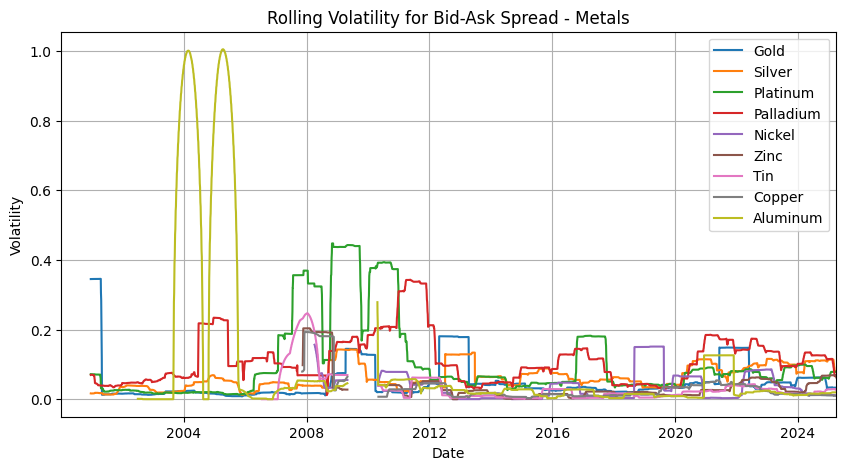

In [ ]:
# Visualizing the rolling volatility for the bid ask spread for all the futures contracts on metals
plt.figure(figsize=(10, 5))
# Plot each futures contract with the corresponding color
for (futures, label), color in zip(futures_contracts_metals, color_palette):
    plt.plot(futures.rolling_volatility_bid_ask_spread, label=label, color=color, alpha=1)
plt.title('Rolling Volatility for Bid-Ask Spread - Metals')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xlim(gold_futures.rolling_volatility_bid_ask_spread.index.min(), gold_futures.rolling_volatility_bid_ask_spread.index.max())
plt.legend()
plt.grid()
plt.show()